In [8]:
# Import libraries and set constants
from dotenv import load_dotenv
import os
import mdai
from mdai.visualize import display_annotations
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np

DEBUG = False

load_dotenv('dot.env')

ACCESS_TOKEN = os.getenv('MDAI_TOKEN')
DATA_DIR = os.getenv('DATA_DIR')
DOMAIN = os.getenv('DOMAIN')
PROJECT_ID = os.getenv('PROJECT_ID')
DATASET_ID = os.getenv('DATASET_ID')
ANNOTATIONS = os.path.join(DATA_DIR, os.getenv('ANNOTATIONS'))
LABEL_ID = os.getenv('LABEL_ID')

print(f"ACCESS_TOKEN={ACCESS_TOKEN}")
print(f"DATA_DIR={DATA_DIR}")
print(f"DOMAIN={DOMAIN}")
print(f"PROJECT_ID={PROJECT_ID}")
print(f"DATASET_ID={DATASET_ID}")
print(f"ANNOTATIONS={ANNOTATIONS}")
print(f"LABEL_ID={LABEL_ID}")

ACCESS_TOKEN=d2b086facd41171613d918a9abefe499
DATA_DIR=data
DOMAIN=ucsf.md.ai
PROJECT_ID=x9N2LJBZ
DATASET_ID=D_V688LQ
ANNOTATIONS=data/mdai_ucsf_project_x9N2LJBZ_annotations_2024-06-27-212520.json
LABEL_ID=L_13yPql


In [9]:
# Start MD.ai client
mdai_client = mdai.Client(domain=DOMAIN, access_token=ACCESS_TOKEN)

# Download the dataset from MD.ai (or use cached version)
project = mdai_client.project(project_id=PROJECT_ID, path=DATA_DIR)
BASE = project.datasets[0].images_dir

Successfully authenticated to ucsf.md.ai.
Using path 'data' for data.
Preparing annotations export for project x9N2LJBZ...                                                
Using cached annotations data for project x9N2LJBZ.
Preparing images export for project x9N2LJBZ...                                                     
Using cached images data for project x9N2LJBZ.


In [10]:
results = mdai.common_utils.json_to_dataframe(ANNOTATIONS)
annotations_df = results['annotations']

# Filter annotations for the free fluid label
free_fluid_annotations = annotations_df[annotations_df['labelId'] == LABEL_ID]

free_fluid_annotations.head()

# Note on paths for each annotation
# The columns StudyInstanceUID and SeriesInstanceUID are used to form the paths
# {BASE}/{StudyInstanceUID}/{SeriesInstanceUID}.mp4

,id,parentId,isImported,isInterpolated,clonedFromModelOutputId,createdAt,createdById,updatedAt,updatedById,updateHistory,...,labelGroupName,annotationMode,color,description,labelName,radlexTagIdsLabel,scope,parentLabelId,datasetId,number
115,A_AeBkJn,None,False,False,None,2024-01-31T22:28:52.281Z,U_MzRXMx,2024-01-31T22:29:11.656Z,U_MzRXMx,"[{'updatedAt': '2024-01-31T22:29:06.007Z', 'up...",...,Fluid,mask,#0288d1,,Free Fluid,[],INSTANCE,None,D_JrYYMV,4
120,A_gp6p04,None,False,False,None,2024-01-31T22:48:01.318Z,U_MzRXMx,2024-01-31T22:48:07.081Z,U_MzRXMx,"[{'updatedAt': '2024-01-31T22:48:07.081Z', 'up...",...,Fluid,mask,#0288d1,,Free Fluid,[],INSTANCE,None,D_JrYYMV,7
219,A_Al8GPM,None,False,False,None,2024-02-23T01:11:43.108Z,U_MzRXMx,2024-02-23T01:12:02.183Z,U_MzRXMx,"[{'updatedAt': '2024-02-23T01:12:02.183Z', 'up...",...,Fluid,mask,#0288d1,,Free Fluid,[],INSTANCE,None,D_JrYYMV,14
225,A_q7G0rW,None,False,False,None,2024-02-23T01:18:09.374Z,U_MzRXMx,2024-02-23T01:18:20.217Z,U_MzRXMx,"[{'updatedAt': '2024-02-23T01:18:20.217Z', 'up...",...,Fluid,mask,#0288d1,,Free Fluid,[],INSTANCE,None,D_JrYYMV,18
325,A_gKNJRy,None,False,False,None,2024-03-05T19:11:08.187Z,U_MzRXMx,2024-03-05T19:11:19.816Z,U_MzRXMx,"[{'updatedAt': '2024-03-05T19:11:19.816Z', 'up...",...,Fluid,mask,#0288d1,,Free Fluid,[],INSTANCE,None,D_JrYYMV,28


In [11]:
# Function to construct the video path
def construct_video_path(base_dir, study_uid, series_uid):
    return os.path.join(base_dir, study_uid, f"{series_uid}.mp4")

# Add video paths to the dataframe using .loc to avoid the SettingWithCopyWarning
free_fluid_annotations = free_fluid_annotations.copy()
free_fluid_annotations.loc[:, 'video_path'] = free_fluid_annotations.apply(
    lambda row: construct_video_path(BASE, row['StudyInstanceUID'], row['SeriesInstanceUID']), axis=1)

# Check if video files exist and add the result to the dataframe using .loc
free_fluid_annotations.loc[:, 'file_exists'] = free_fluid_annotations['video_path'].apply(os.path.exists)

# Count the number of annotations with and without corresponding video files
num_with_files = free_fluid_annotations['file_exists'].sum()
num_without_files = len(free_fluid_annotations) - num_with_files

print(f"Annotations with corresponding video files: {num_with_files}")
print(f"Annotations without corresponding video files: {num_without_files}")


Annotations with corresponding video files: 226
Annotations without corresponding video files: 5


In [12]:
def display_annotation(row):
    video_path = row['video_path']
    frame_number = int(row['frameNumber'])
    foreground = row['data']['foreground']

    # Load the video file
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()

    if ret:
        # Convert the frame to RGB (OpenCV loads in BGR)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Create a copy of the frame for annotation
        frame_annotated = frame_rgb.copy()

        # Draw the annotation on the frame
        for polygon in foreground:
            pts = np.array(polygon, np.int32)
            pts = pts.reshape((-1, 1, 2))
            cv2.polylines(frame_annotated, [pts], isClosed=True, color=(255, 0, 0), thickness=2)
            cv2.fillPoly(frame_annotated, [pts], color=(255, 0, 0, 50))

        # Display the frames
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(frame_rgb)
        plt.title('Original Frame')

        plt.subplot(1, 2, 2)
        plt.imshow(frame_annotated)
        plt.title('Annotated Frame')

        plt.show()
    else:
        print("Failed to read the frame from the video.")



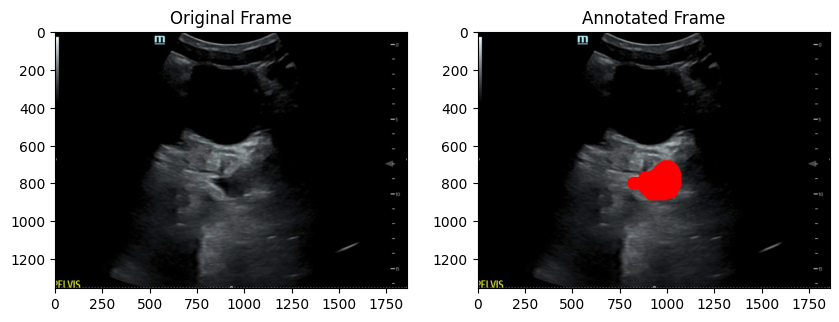

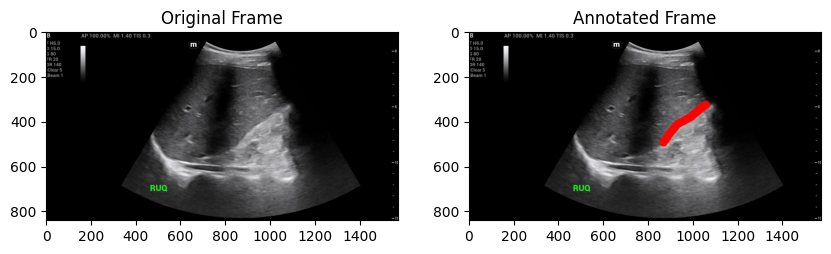

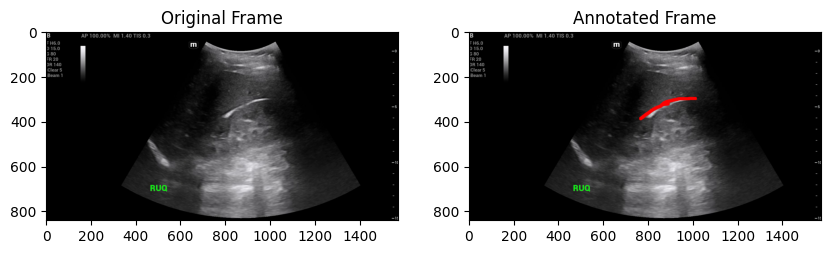

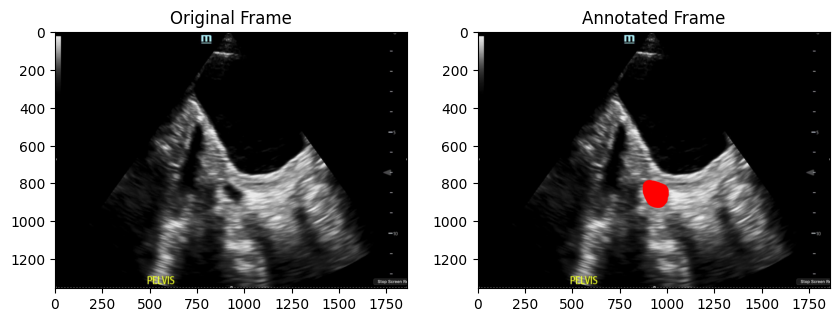

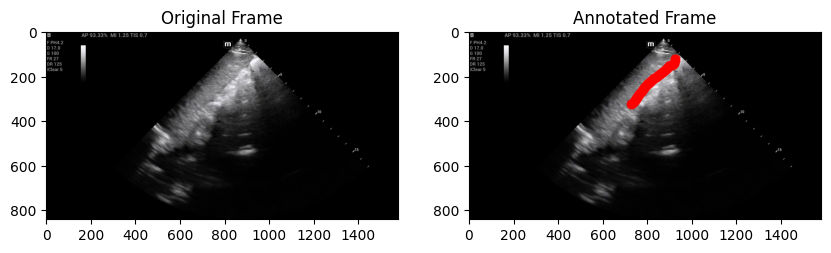

In [13]:

# Select five random annotations with corresponding video files
# random_annotations = free_fluid_annotations[free_fluid_annotations['file_exists']].sample(n=5, random_state=42)
random_annotations = free_fluid_annotations[free_fluid_annotations['file_exists']].sample(n=5)

# Display the selected annotations
for index, row in random_annotations.iterrows():
    display_annotation(row)

In [15]:
def draw_polygon(img, points, color=(255, 0, 0)):
    pts = np.array(points, np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.polylines(img, [pts], isClosed=True, color=color, thickness=2)
    cv2.fillPoly(img, [pts], color=color + (50,))

def track_free_fluid(annotation):
    video_path = annotation['video_path']
    frame_number = int(annotation['frameNumber'])
    foreground = annotation['data']['foreground']

    cap = cv2.VideoCapture(video_path)

    # Move to the annotated frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, old_frame = cap.read()

    if not ret:
        print(f"Failed to read the frame number {frame_number} from the video.")
        return

    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

    # Initialize points for tracking
    p0 = np.array(foreground, np.float32).reshape(-1, 1, 2)

    mask = np.zeros_like(old_frame)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None)

        # Select good points
        good_new = p1[st == 1]
        good_old = p0[st == 1]

        # Draw the tracks
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv2.line(mask, (a, b), (c, d), (0, 255, 0), 2)
            frame = cv2.circle(frame, (a, b), 5, (0, 255, 0), -1)

        img = cv2.add(frame, mask)

        cv2.imshow('frame', img)
        if cv2.waitKey(30) & 0xFF == 27:
            break

        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)

    cap.release()
    cv2.destroyAllWindows()

def display_annotation(annotation):
    video_path = annotation['video_path']
    frame_number = int(annotation['frameNumber'])
    foreground = annotation['data']['foreground']

    cap = cv2.VideoCapture(video_path)

    # Move to the annotated frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()

    if not ret:
        print(f"Failed to read the frame number {frame_number} from the video.")
        return

    annotated_frame = frame.copy()
    draw_polygon(annotated_frame, foreground[0])

    # Display the frame with and without annotation
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    ax[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Original Frame')
    ax[1].imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
    ax[1].set_title('Annotated Frame')
    plt.show()

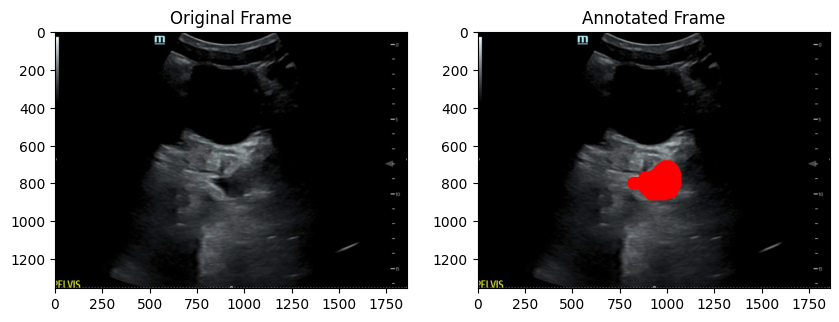

TypeError: track_free_fluid() missing 2 required positional arguments: 'frame_number' and 'foreground'

In [16]:
# Example usage:
for _, annotation in random_annotations.iterrows():
    display_annotation(annotation)
    track_free_fluid(annotation)